In [1]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
from torch import optim
from torch.autograd import Variable
import numpy as np
import os
import math
from torch import nn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt  
from sklearn import preprocessing
import itertools
import random
import torch.nn.functional as F
from exploit_pred import *
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
class TorchDataset(Dataset):
    def __init__(self, trs_file, label_file, plaintext_file, trace_num, trace_offset, trace_length):
        self.trs_file = trs_file
        self.label_file = label_file
        self.plaintext_file = plaintext_file
        self.trace_num = trace_num
        self.trace_offset = trace_offset
        self.trace_length = trace_length
        self.ToTensor = transforms.ToTensor()
    def __getitem__(self, i):
        index = i % self.trace_num
        trace = self.trs_file[index,:]
        label = self.label_file[index]
        plaintext = self.plaintext_file[index]
        trace = trace[self.trace_offset:self.trace_offset+self.trace_length]
        trace = np.reshape(trace,(1,-1))
        trace = self.ToTensor(trace)
        trace = np.reshape(trace, (1,-1))
        label = torch.tensor(label, dtype=torch.long) 
        return trace.float(), label, plaintext
    def __len__(self):
        return self.trace_num
    
### data loader for training
def load_training(batch_size, kwargs):
    data = TorchDataset(**kwargs)
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
    return train_loader

### data loader for testing
def load_testing(batch_size, kwargs):
    data = TorchDataset(**kwargs)
    test_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False, drop_last=True)
    return test_loader

In [3]:
Sbox = [
    99, 124, 119, 123, 242, 107, 111, 197, 48, 1, 103, 43, 254, 215, 171, 118,
    202, 130, 201, 125, 250, 89, 71, 240, 173, 212, 162, 175, 156, 164, 114, 192,
    183, 253, 147, 38, 54, 63, 247, 204, 52, 165, 229, 241, 113, 216, 49, 21, 4,
    199, 35, 195, 24, 150, 5, 154, 7, 18, 128, 226, 235, 39, 178, 117, 9, 131, 44,
    26, 27, 110, 90, 160, 82, 59, 214, 179, 41, 227, 47, 132, 83, 209, 0, 237, 32,
    252, 177, 91, 106, 203, 190, 57, 74, 76, 88, 207, 208, 239, 170, 251, 67, 77,
    51, 133, 69, 249, 2, 127, 80, 60, 159, 168, 81, 163, 64, 143, 146, 157, 56, 245,
    188, 182, 218, 33, 16, 255, 243, 210, 205, 12, 19, 236, 95, 151, 68, 23, 196,
    167, 126, 61, 100, 93, 25, 115, 96, 129, 79, 220, 34, 42, 144, 136, 70, 238,
    184, 20, 222, 94, 11, 219, 224, 50, 58, 10, 73, 6, 36, 92, 194, 211, 172, 98,
    145, 149, 228, 121, 231, 200, 55, 109, 141, 213, 78, 169, 108, 86, 244, 234,
    101, 122, 174, 8, 186, 120, 37, 46, 28, 166, 180, 198, 232, 221, 116, 31, 75,
    189, 139, 138, 112, 62, 181, 102, 72, 3, 246, 14, 97, 53, 87, 185, 134, 193,
    29, 158, 225, 248, 152, 17, 105, 217, 142, 148, 155, 30, 135, 233, 206, 85, 40,
    223, 140, 161, 137, 13, 191, 230, 66, 104, 65, 153, 45, 15, 176, 84, 187, 22
]


def CA_train(epoch, model):
    """
    Train the model for one epoch using cross-attention training.
    
    Parameters:
    - epoch: current epoch number.
    - model: the neural network model to be trained.
    """
    model.train()
    iter_source = iter(source_train_loader)
    iter_target = iter(target_train_loader)
    num_iter_target = len(target_train_loader)
    
    # Pre-load target domain data for efficiency
    train_trace_all = torch.zeros((num_iter_target, batch_size, 1, trace_length))
    train_pt_all = torch.zeros((num_iter_target, batch_size))
    for i in range(num_iter_target):
        train_trace_all[i, :, :, :], _, train_pt_all[i, :] = iter_target.next()
    
    num_iter = len(source_train_loader)
    clf_criterion = nn.CrossEntropyLoss()
    
    for i in range(1, num_iter + 1):
        source_data, source_label, source_pt = iter_source.next()
        target_data = train_trace_all[(i - 1) % num_iter_target, :, :, :]
        target_pt = train_pt_all[(i - 1) % num_iter_target, :]
        
        if cuda:
            source_data, source_label, source_pt = source_data.cuda(), source_label.cuda(), source_pt.cuda()
            target_data, target_pt = target_data.cuda(), target_pt.cuda()

        source_data = Variable(source_data)
        source_label = Variable(source_label)
        source_pt = Variable(source_pt)
        target_data = Variable(target_data)
        target_pt = Variable(target_pt)

        optimizer.zero_grad()
        source_preds, mmd_loss = model(source_data, target_data, source_pt, target_pt)
        preds = source_preds.data.max(1, keepdim=True)[1]
        clf_loss = clf_criterion(source_preds, source_label)
        loss = clf_loss + lambda_ * mmd_loss
        loss.backward()
        optimizer.step()

        if i % log_interval == 0:
            print('Train Epoch {}: [{}/{} ({:.0f}%)]\t'
                  'total_loss: {:.6f}\tclf_loss: {:.6f}\t'
                  'mmd_loss: {:.6f}'.format(
                      epoch, i * len(source_data),
                      len(source_train_loader) * batch_size,
                      100. * i / len(source_train_loader),
                      loss.data, clf_loss.data, mmd_loss.data))


def CA_validation(model):
    """
    Validate the model on the source validation dataset and report losses and accuracy.
    
    Parameters:
    - model: the neural network model to be evaluated.
    
    Returns:
    - total_loss: average total loss over the validation set.
    - total_mmd_loss: average MMD loss over the validation set.
    """
    clf_criterion = nn.CrossEntropyLoss()
    model.eval()
    iter_source = iter(source_valid_loader)
    iter_target = iter(target_train_loader)
    
    num_iter_target = len(target_train_loader)
    train_trace_all = torch.zeros((num_iter_target, batch_size, 1, trace_length))
    train_pt_all = torch.zeros((num_iter_target, batch_size))
    for i in range(num_iter_target):
        train_trace_all[i, :, :, :], _, train_pt_all[i, :] = iter_target.next()
    
    num_iter = len(source_valid_loader)
    total_clf_loss = 0
    total_mmd_loss = 0
    total_loss = 0
    correct = 0

    for i in range(1, num_iter + 1):
        source_data, source_label, source_pt = iter_source.next()
        target_data = train_trace_all[(i - 1) % num_iter_target, :, :, :]
        target_pt = train_pt_all[(i - 1) % num_iter_target, :]
        
        if cuda:
            source_data, source_label, source_pt = source_data.cuda(), source_label.cuda(), source_pt.cuda()
            target_data, target_pt = target_data.cuda(), target_pt.cuda()
        
        source_data = Variable(source_data)
        source_label = Variable(source_label)
        source_pt = Variable(source_pt)
        target_data = Variable(target_data)
        target_pt = Variable(target_pt)
        
        valid_preds, mmd_loss = model(source_data, target_data, source_pt, target_pt)
        clf_loss = clf_criterion(valid_preds, source_label)
        loss = clf_loss + lambda_ * mmd_loss
        
        total_clf_loss += clf_loss
        total_mmd_loss += mmd_loss
        total_loss += loss
        
        pred = valid_preds.data.max(1)[1]
        correct += pred.eq(source_label.data.view_as(pred)).cpu().sum()
    
    total_loss /= len(source_valid_loader)
    total_clf_loss /= len(source_valid_loader)
    total_mmd_loss /= len(source_valid_loader)
    
    print('Validation: total_loss: {:.4f}, clf_loss: {:.4f}, mmd_loss: {:.4f}, accuracy: {}/{} ({:.2f}%)'.format(
        total_loss.data, total_clf_loss, total_mmd_loss,
        correct, len(source_valid_loader.dataset),
        100. * correct / len(source_valid_loader.dataset)))
    
    return total_loss, total_mmd_loss


def test_rank(model, device_id, disp_GE=True, model_flag='pretrained'):
    """
    Test the model and compute metrics, including confusion matrix and guessing entropy.
    
    Parameters:
    - model: the current model.
    - device_id: id of the tested device.
    - disp_GE: whether to display guessing entropy (GE) results.
    - model_flag: a string identifier for naming GE result.
    """
    model.eval()
    test_loss = 0
    correct = 0
    epoch = 0
    clf_criterion = nn.CrossEntropyLoss()

    if device_id == source_device_id:
        test_num = source_test_num
        test_loader = source_test_loader
        real_key = real_key_01
    else:
        test_num = target_test_num
        test_loader = target_test_loader
        real_key = real_key_02

    predlist = torch.zeros(0, dtype=torch.long, device='cpu')
    lbllist = torch.zeros(0, dtype=torch.long, device='cpu')
    test_preds_all = torch.zeros((test_num, class_num), dtype=torch.float, device='cpu')

    for data, label, plaintext in test_loader:
        if cuda:
            data, label, plaintext = data.cuda(), label.cuda(), plaintext.cuda()
        data, label, plaintext = Variable(data), Variable(label), Variable(plaintext)
        test_preds = model(data, plaintext)
        test_loss += clf_criterion(test_preds, label)
        pred = test_preds.data.max(1)[1]

        softmax = nn.Softmax(dim=1)
        test_preds_all[epoch * batch_size:(epoch + 1) * batch_size, :] = softmax(test_preds)

        predlist = torch.cat([predlist, pred.view(-1).cpu()])
        lbllist = torch.cat([lbllist, label.view(-1).cpu()])
        correct += pred.eq(label.data.view_as(pred)).cpu().sum()
        epoch += 1

    test_loss /= len(test_loader)
    print('Target test loss: {:.4f}, Target test accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss.data, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    confusion_mat = confusion_matrix(lbllist.numpy(), predlist.numpy())
    plot_sonfusion_matrix(confusion_mat, classes=range(class_num))
    
    if disp_GE:
        plot_guessing_entropy(test_preds_all.numpy(), real_key, device_id, model_flag)


def guassian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    """
    Compute the Gaussian kernel matrix between source and target data.
    
    Parameters:
    - source: source data tensor.
    - target: target data tensor.
    - kernel_mul: multiplicative step for bandwidth.
    - kernel_num: number of Gaussian kernels.
    - fix_sigma: fixed bandwidth value (if provided).
    
    Returns:
    - Sum of the Gaussian kernel matrices.
    """
    n_samples = int(source.size(0)) + int(target.size(0))
    total = torch.cat([source, target], dim=0)
    total0 = total.unsqueeze(0).expand(total.size(0), total.size(0), total.size(1))
    total1 = total.unsqueeze(1).expand(total.size(0), total.size(0), total.size(1))
    
    L2_distance = ((total0 - total1) ** 2).sum(2)
    
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance.data) / (n_samples ** 2 - n_samples)
    
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul ** i) for i in range(kernel_num)]
    
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
    return sum(kernel_val)


def mmd_rbf(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    """
    Compute the Maximum Mean Discrepancy (MMD) loss using an RBF kernel.
    
    Parameters:
    - source: source data tensor.
    - target: target data tensor.
    - kernel_mul: multiplicative factor for kernel bandwidth.
    - kernel_num: number of kernels.
    - fix_sigma: fixed sigma value.
    
    Returns:
    - MMD loss value.
    """
    batch_size = int(source.size(0))
    kernels = guassian_kernel(source, target, kernel_mul=kernel_mul,
                              kernel_num=kernel_num, fix_sigma=fix_sigma)
    
    XX = kernels[:batch_size, :batch_size]  
    YY = kernels[batch_size:, batch_size:]  
    XY = kernels[:batch_size, batch_size:]  
    YX = kernels[batch_size:, :batch_size] 
    
    loss = torch.mean(XX + YY - XY - YX)
    return loss


def plot_guessing_entropy(preds, real_key, device_id, model_flag):
    """
    Plot guessing entropy based on model predictions.
    
    Parameters:
    - preds: softmax predictions from the model.
    - real_key: the actual cryptographic key.
    - device_id: identifier for the tested device.
    - model_flag: a string for naming GE result.
    """
    model_name = "CA"
    nb_traces_attacks = 1000
    nb_attacks = 200

    if device_id == target_device_id:
        plaintext = plaintexts_target[target_train_num:target_train_num + target_test_num]
        ct = ct_target[target_train_num:target_train_num + target_test_num]
        id_num = target_device_id
    elif device_id == source_device_id:
        plaintext = plaintexts_source
        ct = ct_source
        id_num = source_device_id

    plt_attack_1 = np.array([plaintext for _ in range(16)]).T
    ct_attack_1 = np.array([ct for _ in range(16)]).T
    key_1 = np.array([real_key for _ in range(16)])

    avg_rank = perform_attacks(nb_traces_attacks, predictions=preds, nb_attacks=nb_attacks,
                               plt=plt_attack_1, ct=ct_attack_1, key=key_1, byte=0,
                               filename=model_name, id_num=id_num)
    
    plt.show()



def plot_sonfusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Plot the confusion matrix.
    
    Parameters:
    - cm: confusion matrix.
    - classes: list of class labels.
    - normalize: if True, normalize the confusion matrix.
    - title: title for the plot.
    - cmap: color map.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    thresh = cm.max() / 2.0
    plt.xticks([i for i in range(len(classes)) if i % 20 == 0],
               [classes[i] for i in range(len(classes)) if i % 20 == 0], rotation=45)
    plt.yticks([i for i in range(len(classes)) if i % 20 == 0],
               [classes[i] for i in range(len(classes)) if i % 20 == 0])
    
    plt.ylim((len(classes) - 0.5, -0.5))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [4]:
# Device and cryptographic key settings
source_device_id = 1
target_device_id = 2
real_key_01 = 0x61
real_key_02 = 0x5F

# Training hyperparameters
lambda_ = 0.02
labeling_method = 'identity' 
preprocess = 'horizontal_standardization' 
batch_size = 100
train_epoch = 200 
lr = 0.001 
log_interval = 40 

# Data splits and trace settings
train_num = 20000
valid_num = 5000
source_test_num = 5000
target_train_num = 500
target_test_num = 5000
trace_offset = 0
trace_length = 500

# File paths for source and target datasets
source_file_path = './Dataset/01_Last_round_ECB_F1_3E/'
target_file_path = './Dataset/02_Last_round_CBC_F2_5F/'

# CUDA settings
no_cuda = False
cuda = not no_cuda and torch.cuda.is_available()
seed = 8
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

# Determine number of classes based on labeling method
if labeling_method == 'identity':
    class_num = 256
elif labeling_method == 'hw':
    class_num = 9

# Load training and attack data for the source
X_train_source = np.load(source_file_path + 'X_train.npy')
Y_train_source = np.load(source_file_path + 'Y_train.npy')
X_attack_source = np.load(source_file_path + 'X_attack.npy')
Y_attack_source = np.load(source_file_path + 'Y_attack.npy')

# Load attack data for the target
X_attack_target = np.load(target_file_path + 'X_attack.npy')
Y_attack_target = np.load(target_file_path + 'Y_attack.npy')

# Load plaintexts and ciphertexts for source and target
plaintexts_source_train = np.load(source_file_path + 'plaintexts_train.npy')
plaintexts_source = np.load(source_file_path + 'plaintexts_attack.npy')
plaintexts_target = np.load(target_file_path + 'plaintexts_attack.npy')
ct_source_train = np.load(source_file_path + 'ct_train.npy')
ct_source = np.load(source_file_path + 'ct_attack.npy')
ct_target = np.load(target_file_path + 'ct_attack.npy')

# Preprocess the traces based on the specified method
if preprocess == 'horizontal_standardization':
    # Standardize source training data
    X_train_source = X_train_source - np.mean(X_train_source, axis=0)
    mn = np.repeat(np.mean(X_train_source, axis=1, keepdims=True), X_train_source.shape[1], axis=1)
    std = np.repeat(np.std(X_train_source, axis=1, keepdims=True), X_train_source.shape[1], axis=1)
    X_train_source = (X_train_source - mn) / std

    # Standardize source attack data
    X_attack_source = X_attack_source - np.mean(X_attack_source, axis=0)
    mn = np.repeat(np.mean(X_attack_source, axis=1, keepdims=True), X_attack_source.shape[1], axis=1)
    std = np.repeat(np.std(X_attack_source, axis=1, keepdims=True), X_attack_source.shape[1], axis=1)
    X_attack_source = (X_attack_source - mn) / std

    # Standardize target attack data
    X_attack_target = X_attack_target - np.mean(X_attack_target, axis=0)
    mn = np.repeat(np.mean(X_attack_target, axis=1, keepdims=True), X_attack_target.shape[1], axis=1)
    std = np.repeat(np.std(X_attack_target, axis=1, keepdims=True), X_attack_target.shape[1], axis=1)
    X_attack_target = (X_attack_target - mn) / std  

elif preprocess == 'horizontal_scaling':
    # Scale data to range [-1, 1] using MinMaxScaler for source training data
    scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X_train_source.T)
    X_train_source = scaler.transform(X_train_source.T).T

    # Scale source attack data
    scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X_attack_source.T)
    X_attack_source = scaler.transform(X_attack_source.T).T

    # Scale target attack data
    scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X_attack_target.T)
    X_attack_target = scaler.transform(X_attack_target.T).T

# Configure parameters for data loaders
kwargs_source_train = {
    'trs_file': X_train_source[0:train_num, :],
    'label_file': Y_train_source[0:train_num],
    'plaintext_file': plaintexts_source_train[0:train_num],
    'trace_num': train_num,
    'trace_offset': trace_offset,
    'trace_length': trace_length,
}

kwargs_source_valid = {
    'trs_file': X_train_source[train_num:train_num + valid_num, :],
    'label_file': Y_train_source[train_num:train_num + valid_num],
    'plaintext_file': plaintexts_source_train[train_num:train_num + valid_num],
    'trace_num': valid_num,
    'trace_offset': trace_offset,
    'trace_length': trace_length,
}

kwargs_source_test = {
    'trs_file': X_attack_source,
    'label_file': Y_attack_source,
    'plaintext_file': plaintexts_source,
    'trace_num': source_test_num,
    'trace_offset': trace_offset,
    'trace_length': trace_length,
}

kwargs_target_train = {
    'trs_file': X_attack_target[0:target_train_num, :],
    'label_file': Y_attack_target[0:target_train_num],
    'plaintext_file': plaintexts_target[0:target_train_num],
    'trace_num': target_train_num,
    'trace_offset': trace_offset,
    'trace_length': trace_length,
}

kwargs_target = {
    'trs_file': X_attack_target[target_train_num:target_train_num + target_test_num, :],
    'label_file': Y_attack_target[target_train_num:target_train_num + target_test_num],
    'plaintext_file': plaintexts_target[target_train_num:target_train_num + target_test_num],
    'trace_num': target_test_num,
    'trace_offset': trace_offset,
    'trace_length': trace_length,
}

# Initialize data loaders
source_train_loader = load_training(batch_size, kwargs_source_train)
source_valid_loader = load_training(batch_size, kwargs_source_valid)
source_test_loader = load_testing(batch_size, kwargs_source_test)
target_train_loader = load_training(batch_size, kwargs_target_train)
target_test_loader = load_testing(batch_size, kwargs_target)

print('Load data complete!')


Load data complete!


# Attention Layer

In [5]:
class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention module using 1D convolutions.

    This module computes scaled dot-product attention over multiple heads.
    It takes source and target inputs, projects them to query, key, and value
    representations across several heads, and then concatenates the outputs.
    """

    def __init__(self, channel_size, num_heads):
        """
        Initialize the MultiHeadAttention module.

        Parameters:
        - channel_size: int, the number of input channels.
        - num_heads: int, the number of attention heads.
        """
        super(MultiHeadAttention, self).__init__()
        assert channel_size % num_heads == 0, "channel_size must be divisible by num_heads"

        self.num_heads = num_heads
        self.head_dim = channel_size // num_heads

        # Create a list of convolution layers for queries, keys, and values for each head.
        self.query_convs = nn.ModuleList(
            [nn.Conv1d(channel_size, self.head_dim, kernel_size=1) for _ in range(num_heads)]
        )
        self.key_convs = nn.ModuleList(
            [nn.Conv1d(channel_size, self.head_dim, kernel_size=1) for _ in range(num_heads)]
        )
        self.value_convs = nn.ModuleList(
            [nn.Conv1d(channel_size, self.head_dim, kernel_size=1) for _ in range(num_heads)]
        )

        # Final linear layer to combine attention head outputs.
        self.fc_out = nn.Conv1d(channel_size, channel_size, kernel_size=1)

    def forward(self, x_source, x_target):
        """
        Forward pass for multi-head attention.

        Parameters:
        - x_source: Tensor of shape (batch_size, channel_size, seq_length)
        - x_target: Tensor of shape (batch_size, channel_size, seq_length)

        Returns:
        - Tensor of shape (batch_size, channel_size, seq_length) after applying attention and residual connection.
        """
        batch_size = x_source.shape[0]

        # Compute query, key, and value projections for each head.
        query_list = [conv(x_source) for conv in self.query_convs]
        key_list = [conv(x_target) for conv in self.key_convs]
        value_list = [conv(x_target) for conv in self.value_convs]

        attention_heads = []
        # Apply attention mechanism per head.
        for i in range(self.num_heads):
            # Compute scaled dot-product attention.
            # Transpose query to (batch_size, seq_length, head_dim) for matmul.
            scores = torch.matmul(query_list[i].transpose(1, 2), key_list[i]) / (self.head_dim ** 0.5)
            attention = F.softmax(scores, dim=-1)
            # Multiply attention weights with value. Transpose back to original dimensions.
            head_output = torch.matmul(attention, value_list[i].transpose(1, 2)).transpose(1, 2)
            attention_heads.append(head_output)

        # Concatenate outputs from all heads along the channel dimension.
        concatenated = torch.cat(attention_heads, dim=1)
        # Apply final linear transformation and add residual connection.
        out = self.fc_out(concatenated)

        return out + x_source

# CA-SCA Models

In [6]:
class Net(nn.Module):
    """
    Baseline network architecture for feature extraction and classification.
    """
    def __init__(self, num_classes=class_num):
        super(Net, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=2),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(16, 32, kernel_size=50),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=50, stride=50),
            nn.Conv1d(32, 64, kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        self.classifier_1 = nn.Sequential(
            nn.Linear(64, 20),
            nn.SELU()
        )
        self.classifier_2 = nn.Sequential(
            nn.Linear(20, 20),
            nn.SELU()
        )
        self.classifier_3 = nn.Sequential(
            nn.Linear(20, 20),
            nn.SELU()
        )
        self.final_classifier = nn.Sequential(
            nn.Linear(20, num_classes)
        )

    def forward(self, input, pt_source):
        """
        Forward pass through the network.
        
        Parameters:
        - input: input tensor.
        - pt_source: plaintext or additional input (unused in this baseline).
        
        Returns:
        - output: class scores.
        """
        x = self.feature(input)
        x = x.view(x.size(0), -1)
        x = self.classifier_1(x)
        x = self.classifier_2(x)
        x = self.classifier_3(x)
        output = self.final_classifier(x)
        return output


class CA_Net(nn.Module):
    """
    Cross-Attention network architecture incorporating domain-specific classifiers
    and a multi-head attention mechanism to align source and target features.
    """
    def __init__(self, num_classes):
        super(CA_Net, self).__init__()
        # Shared feature extractor (encoder)
        self.feature = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=2),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(16, 32, kernel_size=50),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=50, stride=50),
            nn.Conv1d(32, 64, kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Flatten()
        )

        # Source domain classifiers
        self.classifier_1 = nn.Sequential(
            nn.Linear(64, 20),
            nn.SELU()
        )
        self.classifier_2 = nn.Sequential(
            nn.Linear(20, 20),
            nn.SELU()
        )
        self.classifier_3 = nn.Sequential(
            nn.Linear(20, 20),
            nn.SELU()
        )
        self.final_classifier = nn.Sequential(
            nn.Linear(20, num_classes)
        )

        # Target domain classifiers
        self.classifier_1_target = nn.Sequential(
            nn.Linear(64, 20),
            nn.SELU()
        )
        self.classifier_2_target = nn.Sequential(
            nn.Linear(20, 20),
            nn.SELU()
        )
        self.classifier_3_target = nn.Sequential(
            nn.Linear(20, 20),
            nn.SELU()
        )
        self.final_classifier_target = nn.Sequential(
            nn.Linear(20, num_classes)
        )

        # Cross-domain multi-head attention module
        self.cross_attention = MultiHeadAttention(64, 8)

    def forward(self, source, target, pt_source, pt_target):
        """
        Forward pass for cross-domain attention network.
        
        Parameters:
        - source: source domain input tensor.
        - target: target domain input tensor.
        - pt_source: plaintext or additional input for source (unused here).
        - pt_target: plaintext or additional input for target (unused here).
        
        Returns:
        - result_source: classification output for source domain.
        - mmd_loss: accumulated MMD loss for feature alignment.
        """
        mmd_loss = 0

        # Features up to a certain point (first 7 layers)
        x_source = self.feature[:7](source)
        x_target = self.feature[:7](target)

        # Apply cross-domain attention
        x_source_att = self.cross_attention(x_source, x_target)
        x_target_att = self.cross_attention(x_target, x_source)

        # Continue feature extraction with the remaining layers
        source_features = self.feature[7:](x_source_att)
        target_features = self.feature[7:](x_target_att)

        # Process source features through source classifiers
        source_1 = self.classifier_1(source_features)
        source_2 = self.classifier_2(source_1)
        source_3 = self.classifier_3(source_2)

        # Process target features through target classifiers
        target_1 = self.classifier_1_target(target_features)
        target_2 = self.classifier_2_target(target_1)
        target_3 = self.classifier_3_target(target_2)

        # Compute MMD loss between corresponding feature representations
        mmd_loss += mmd_rbf(source_features, target_features)
        mmd_loss += mmd_rbf(source_1, target_1)
        mmd_loss += mmd_rbf(source_2, target_2)
        mmd_loss += mmd_rbf(source_3, target_3)

        # Final classification results for each domain
        result_source = self.final_classifier(source_3)
        result_target = self.final_classifier_target(target_3)

        return result_source, mmd_loss


# Model Training

In [7]:
# Create the cross-attention network
CA_model = CA_Net(num_classes=class_num)
print('Construct model complete')
if cuda:
    CA_model.cuda()

min_loss = 1000

# Initialize optimizer for specific parameters of CA_model
optimizer = torch.optim.Adam([
    {'params': CA_model.feature.parameters()},
    {'params': CA_model.classifier_1.parameters()},
    {'params': CA_model.classifier_2.parameters()},
    {'params': CA_model.classifier_3.parameters()},
    {'params': CA_model.classifier_1_target.parameters()},
    {'params': CA_model.classifier_2_target.parameters()},
    {'params': CA_model.classifier_3_target.parameters()},
    {'params': CA_model.final_classifier.parameters()}
], lr=lr)

# Use 100 epochs for training
train_epoch = 100

# Create folder to save the model if it does not exist
folder_name_1 = './models_CA/'
if not os.path.exists(folder_name_1):
    os.makedirs(folder_name_1)

# Training loop
for epoch in range(1, train_epoch + 1):
    print(f'Train Epoch {epoch}:')
    CA_train(epoch, CA_model)
    
    # Validate the model without gradient computation
    with torch.no_grad():
        valid_loss, valid_mmd_loss = CA_validation(CA_model)
        # Save the model if a new minimum MMD loss is achieved
        if valid_mmd_loss < min_loss:
            min_loss = valid_mmd_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': CA_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, f'./models_CA/CA_model_{source_device_id}_to_{target_device_id}.pth')
            print(f"New minimum validation loss {valid_mmd_loss:.4f}, model saved.")


Construct model complete
Train Epoch 1:
Train Epoch 1: [4000/20000 (20%)]	total_loss: 5.614504	clf_loss: 5.580310	mmd_loss: 1.709730
Train Epoch 1: [8000/20000 (40%)]	total_loss: 5.557817	clf_loss: 5.531273	mmd_loss: 1.327174
Train Epoch 1: [12000/20000 (60%)]	total_loss: 5.548291	clf_loss: 5.530871	mmd_loss: 0.870976
Train Epoch 1: [16000/20000 (80%)]	total_loss: 5.512042	clf_loss: 5.499212	mmd_loss: 0.641455
Train Epoch 1: [20000/20000 (100%)]	total_loss: 5.394913	clf_loss: 5.384399	mmd_loss: 0.525724
Validation: total_loss: 5.4229, clf_loss: 5.4097, mmd_loss: 0.6578, accuracy: 27/5000 (0.54%)
New minimum validation loss 0.6578, model saved.
Train Epoch 2:
Train Epoch 2: [4000/20000 (20%)]	total_loss: 5.432815	clf_loss: 5.419052	mmd_loss: 0.688182
Train Epoch 2: [8000/20000 (40%)]	total_loss: 5.246673	clf_loss: 5.235253	mmd_loss: 0.571009
Train Epoch 2: [12000/20000 (60%)]	total_loss: 5.051414	clf_loss: 5.042273	mmd_loss: 0.457053
Train Epoch 2: [16000/20000 (80%)]	total_loss: 5.0499

Train Epoch 14: [12000/20000 (60%)]	total_loss: 3.953187	clf_loss: 3.947172	mmd_loss: 0.300788
Train Epoch 14: [16000/20000 (80%)]	total_loss: 3.783326	clf_loss: 3.779265	mmd_loss: 0.203064
Train Epoch 14: [20000/20000 (100%)]	total_loss: 3.845464	clf_loss: 3.840245	mmd_loss: 0.260973
Validation: total_loss: 3.9903, clf_loss: 3.9857, mmd_loss: 0.2272, accuracy: 191/5000 (3.82%)
New minimum validation loss 0.2272, model saved.
Train Epoch 15:
Train Epoch 15: [4000/20000 (20%)]	total_loss: 3.780056	clf_loss: 3.773283	mmd_loss: 0.338664
Train Epoch 15: [8000/20000 (40%)]	total_loss: 3.924082	clf_loss: 3.917516	mmd_loss: 0.328332
Train Epoch 15: [12000/20000 (60%)]	total_loss: 3.816533	clf_loss: 3.810213	mmd_loss: 0.315982
Train Epoch 15: [16000/20000 (80%)]	total_loss: 3.799124	clf_loss: 3.791544	mmd_loss: 0.379001
Train Epoch 15: [20000/20000 (100%)]	total_loss: 3.796998	clf_loss: 3.791426	mmd_loss: 0.278573
Validation: total_loss: 3.9149, clf_loss: 3.9099, mmd_loss: 0.2512, accuracy: 19

Train Epoch 28: [12000/20000 (60%)]	total_loss: 3.720926	clf_loss: 3.716225	mmd_loss: 0.235049
Train Epoch 28: [16000/20000 (80%)]	total_loss: 3.799050	clf_loss: 3.794801	mmd_loss: 0.212454
Train Epoch 28: [20000/20000 (100%)]	total_loss: 3.679374	clf_loss: 3.674238	mmd_loss: 0.256785
Validation: total_loss: 3.7974, clf_loss: 3.7916, mmd_loss: 0.2906, accuracy: 254/5000 (5.08%)
Train Epoch 29:
Train Epoch 29: [4000/20000 (20%)]	total_loss: 3.773712	clf_loss: 3.767833	mmd_loss: 0.293925
Train Epoch 29: [8000/20000 (40%)]	total_loss: 3.747476	clf_loss: 3.742212	mmd_loss: 0.263164
Train Epoch 29: [12000/20000 (60%)]	total_loss: 3.613450	clf_loss: 3.609414	mmd_loss: 0.201795
Train Epoch 29: [16000/20000 (80%)]	total_loss: 3.810901	clf_loss: 3.805286	mmd_loss: 0.280770
Train Epoch 29: [20000/20000 (100%)]	total_loss: 3.586815	clf_loss: 3.580009	mmd_loss: 0.340293
Validation: total_loss: 3.7967, clf_loss: 3.7918, mmd_loss: 0.2473, accuracy: 207/5000 (4.14%)
Train Epoch 30:
Train Epoch 30: [4

Train Epoch 42: [16000/20000 (80%)]	total_loss: 3.645542	clf_loss: 3.640761	mmd_loss: 0.239055
Train Epoch 42: [20000/20000 (100%)]	total_loss: 3.553211	clf_loss: 3.549247	mmd_loss: 0.198217
Validation: total_loss: 3.7104, clf_loss: 3.7051, mmd_loss: 0.2640, accuracy: 284/5000 (5.68%)
Train Epoch 43:
Train Epoch 43: [4000/20000 (20%)]	total_loss: 3.616282	clf_loss: 3.612125	mmd_loss: 0.207846
Train Epoch 43: [8000/20000 (40%)]	total_loss: 3.458183	clf_loss: 3.453036	mmd_loss: 0.257366
Train Epoch 43: [12000/20000 (60%)]	total_loss: 3.716075	clf_loss: 3.710385	mmd_loss: 0.284476
Train Epoch 43: [16000/20000 (80%)]	total_loss: 3.619711	clf_loss: 3.615032	mmd_loss: 0.233911
Train Epoch 43: [20000/20000 (100%)]	total_loss: 3.479296	clf_loss: 3.472952	mmd_loss: 0.317227
Validation: total_loss: 3.6949, clf_loss: 3.6897, mmd_loss: 0.2588, accuracy: 262/5000 (5.24%)
Train Epoch 44:
Train Epoch 44: [4000/20000 (20%)]	total_loss: 3.466353	clf_loss: 3.458708	mmd_loss: 0.382244
Train Epoch 44: [80

Train Epoch 56: [16000/20000 (80%)]	total_loss: 3.646867	clf_loss: 3.638402	mmd_loss: 0.423255
Train Epoch 56: [20000/20000 (100%)]	total_loss: 3.488966	clf_loss: 3.483693	mmd_loss: 0.263679
Validation: total_loss: 3.5775, clf_loss: 3.5714, mmd_loss: 0.3061, accuracy: 401/5000 (8.02%)
Train Epoch 57:
Train Epoch 57: [4000/20000 (20%)]	total_loss: 3.319037	clf_loss: 3.312568	mmd_loss: 0.323448
Train Epoch 57: [8000/20000 (40%)]	total_loss: 3.168595	clf_loss: 3.163463	mmd_loss: 0.256582
Train Epoch 57: [12000/20000 (60%)]	total_loss: 3.357755	clf_loss: 3.350933	mmd_loss: 0.341132
Train Epoch 57: [16000/20000 (80%)]	total_loss: 3.322667	clf_loss: 3.315316	mmd_loss: 0.367514
Train Epoch 57: [20000/20000 (100%)]	total_loss: 3.339643	clf_loss: 3.333019	mmd_loss: 0.331177
Validation: total_loss: 3.4740, clf_loss: 3.4684, mmd_loss: 0.2810, accuracy: 416/5000 (8.32%)
Train Epoch 58:
Train Epoch 58: [4000/20000 (20%)]	total_loss: 3.314350	clf_loss: 3.307837	mmd_loss: 0.325681
Train Epoch 58: [80

Train Epoch 70: [20000/20000 (100%)]	total_loss: 3.370880	clf_loss: 3.365023	mmd_loss: 0.292851
Validation: total_loss: 3.3862, clf_loss: 3.3809, mmd_loss: 0.2650, accuracy: 482/5000 (9.64%)
Train Epoch 71:
Train Epoch 71: [4000/20000 (20%)]	total_loss: 3.079513	clf_loss: 3.071163	mmd_loss: 0.417527
Train Epoch 71: [8000/20000 (40%)]	total_loss: 2.942627	clf_loss: 2.937657	mmd_loss: 0.248507
Train Epoch 71: [12000/20000 (60%)]	total_loss: 3.147722	clf_loss: 3.143261	mmd_loss: 0.223014
Train Epoch 71: [16000/20000 (80%)]	total_loss: 3.361418	clf_loss: 3.357024	mmd_loss: 0.219704
Train Epoch 71: [20000/20000 (100%)]	total_loss: 3.144991	clf_loss: 3.140266	mmd_loss: 0.236255
Validation: total_loss: 3.3914, clf_loss: 3.3862, mmd_loss: 0.2568, accuracy: 489/5000 (9.78%)
Train Epoch 72:
Train Epoch 72: [4000/20000 (20%)]	total_loss: 3.141270	clf_loss: 3.135572	mmd_loss: 0.284904
Train Epoch 72: [8000/20000 (40%)]	total_loss: 3.088210	clf_loss: 3.082236	mmd_loss: 0.298691
Train Epoch 72: [120

Train Epoch 84: [20000/20000 (100%)]	total_loss: 2.967415	clf_loss: 2.962823	mmd_loss: 0.229618
Validation: total_loss: 3.3128, clf_loss: 3.3065, mmd_loss: 0.3155, accuracy: 543/5000 (10.86%)
Train Epoch 85:
Train Epoch 85: [4000/20000 (20%)]	total_loss: 3.108760	clf_loss: 3.102678	mmd_loss: 0.304143
Train Epoch 85: [8000/20000 (40%)]	total_loss: 3.170191	clf_loss: 3.165530	mmd_loss: 0.233032
Train Epoch 85: [12000/20000 (60%)]	total_loss: 3.130876	clf_loss: 3.125611	mmd_loss: 0.263230
Train Epoch 85: [16000/20000 (80%)]	total_loss: 3.046938	clf_loss: 3.041270	mmd_loss: 0.283414
Train Epoch 85: [20000/20000 (100%)]	total_loss: 3.148879	clf_loss: 3.142910	mmd_loss: 0.298447
Validation: total_loss: 3.3096, clf_loss: 3.3045, mmd_loss: 0.2558, accuracy: 562/5000 (11.24%)
Train Epoch 86:
Train Epoch 86: [4000/20000 (20%)]	total_loss: 3.097910	clf_loss: 3.091969	mmd_loss: 0.297068
Train Epoch 86: [8000/20000 (40%)]	total_loss: 3.129459	clf_loss: 3.125334	mmd_loss: 0.206217
Train Epoch 86: [1

Train Epoch 98: [20000/20000 (100%)]	total_loss: 2.998631	clf_loss: 2.993570	mmd_loss: 0.253044
Validation: total_loss: 3.2331, clf_loss: 3.2277, mmd_loss: 0.2675, accuracy: 585/5000 (11.70%)
Train Epoch 99:
Train Epoch 99: [4000/20000 (20%)]	total_loss: 2.808001	clf_loss: 2.800751	mmd_loss: 0.362491
Train Epoch 99: [8000/20000 (40%)]	total_loss: 3.109621	clf_loss: 3.103707	mmd_loss: 0.295677
Train Epoch 99: [12000/20000 (60%)]	total_loss: 2.918057	clf_loss: 2.912146	mmd_loss: 0.295566
Train Epoch 99: [16000/20000 (80%)]	total_loss: 3.038559	clf_loss: 3.033028	mmd_loss: 0.276579
Train Epoch 99: [20000/20000 (100%)]	total_loss: 2.873594	clf_loss: 2.868539	mmd_loss: 0.252750
Validation: total_loss: 3.2093, clf_loss: 3.2036, mmd_loss: 0.2863, accuracy: 621/5000 (12.42%)
Train Epoch 100:
Train Epoch 100: [4000/20000 (20%)]	total_loss: 2.947727	clf_loss: 2.942873	mmd_loss: 0.242714
Train Epoch 100: [8000/20000 (40%)]	total_loss: 2.688229	clf_loss: 2.682788	mmd_loss: 0.272036
Train Epoch 100

# CA-SCA rank

Construct model complete
Results after CA-SCA:
Result on target device:
Target test loss: 7.4944, Target test accuracy: 63/5000 (1.26%)



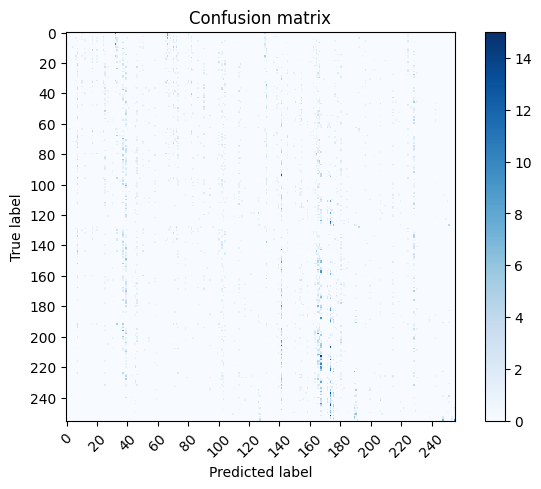

Number of times rank: 0.
Number of times rank: 50.
Number of times rank: 100.
Number of times rank: 150.


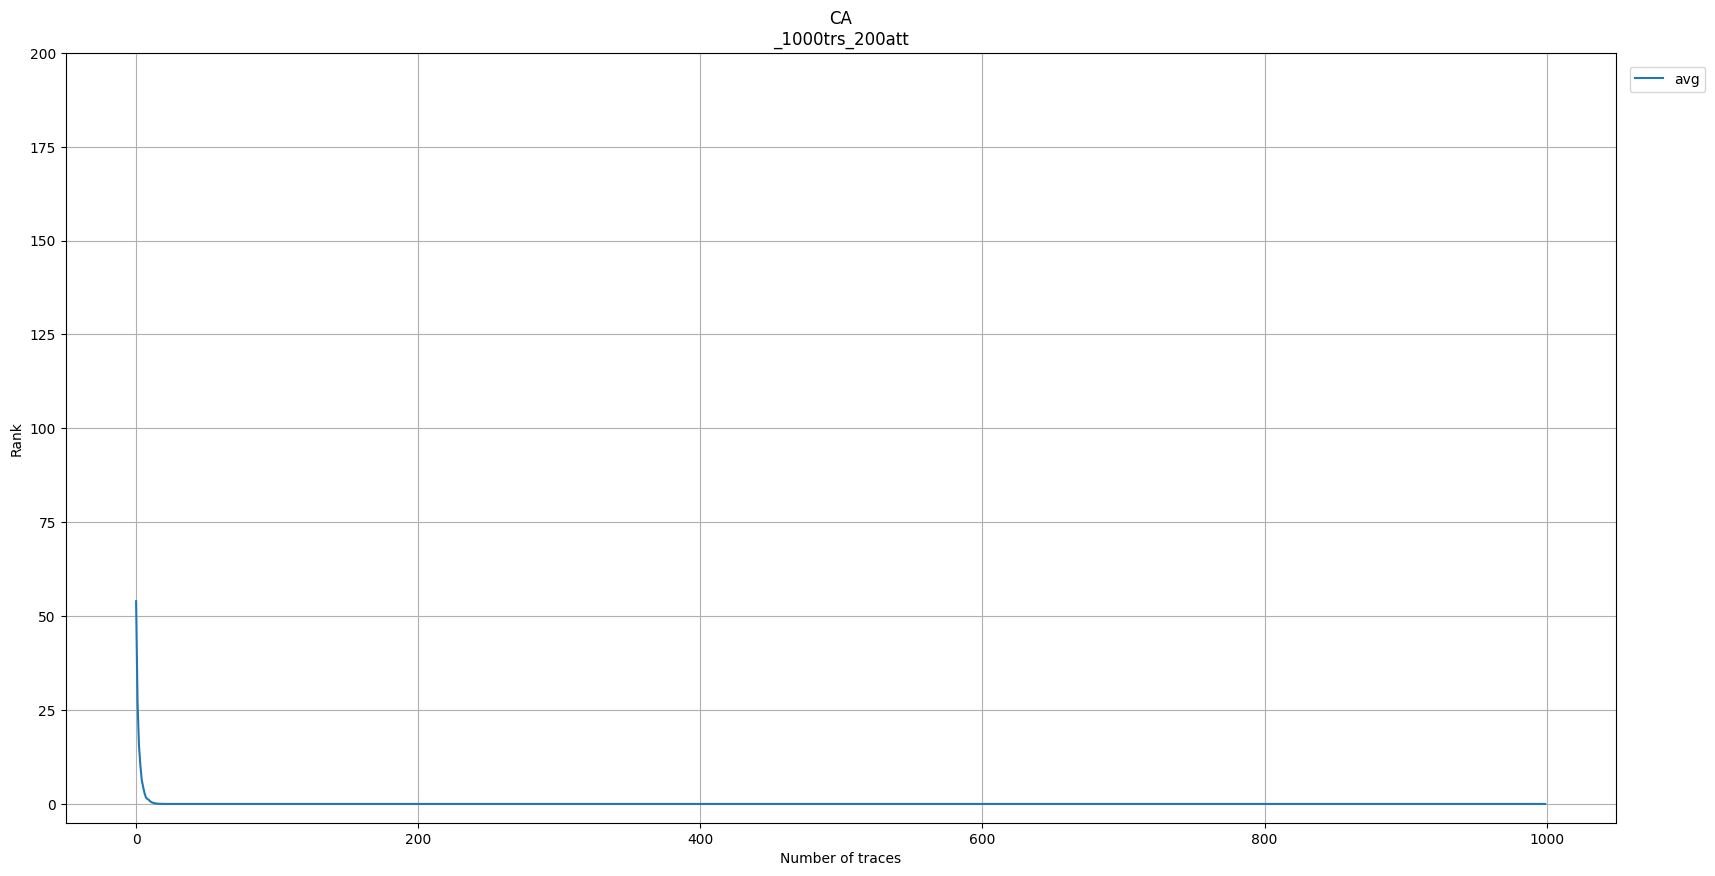

In [8]:
# Create a network
stage_name = 'CA'
model = Net(num_classes=class_num)
print('Construct model complete')
if cuda:
    model.cuda()

# Load the checkpoint from the cross-attention model
checkpoint_path = './models_CA/CA_model_{}_to_{}.pth'.format(source_device_id, target_device_id)
checkpoint = torch.load(checkpoint_path)
train_dict_cdp = checkpoint['model_state_dict']

# Filter parameters that exist in the current model's state dictionary
filtered_params = {k: v for k, v in train_dict_cdp.items() if k in model.state_dict()}
model.load_state_dict(filtered_params, strict=False)

# Evaluate the model after CA-SCA training
print('Results after CA-SCA:')
with torch.no_grad():
    # Uncomment below to evaluate on the source device if desired
    # print('Result on source device:')
    # test_rank(model, source_device_id, model_flag='source')
    print('Result on target device:')
    test_rank(model, target_device_id, model_flag='target')